In [1]:
%matplotlib inline
import d2ltvm
import tvm
from tvm import te
import numpy as np
import timeit

target = 'llvm'

successd...



In [2]:
def np_matmul_timer(n):
    timer = timeit.Timer(setup='import numpy as np\n'
                'import d2ltvm\n'
                'a, b, c = d2ltvm.get_abc(%s)' % str((n, n)),
                stmt='np.dot(a, b, out=c)')
    return timer.timeit

sizes = 2 ** np.arange(5, 12 ,1)
exe_times = [d2ltvm.bench_workload(np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes ** 3 / 1e9 / exe_times

# Default Schedule

In [3]:
def default(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    return s, (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i: int32, 0, 64) {
    for (j: int32, 0, 64) {
      C[((i*64) + j)] = 0f32
      for (k: int32, 0, 64) {
        let cse_var_2: int32 = (i*64)
        let cse_var_1: int32 = (cse_var_2 + j)
        C[cse_var_1] = (C[cse_var_1] + (A[(cse_var_2 + k)]*B[((k*64) + j)]))
      }
    }
  }
}




In [4]:
def bench_matmul_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(n)
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.device(target, 0)
        a, b, c = d2ltvm.get_abc((n, n), lambda x: tvm.nd.array(x, device=ctx))
        times.append(d2ltvm.bench_workload(workload))
        
    return 2 * sizes ** 3 / 1e9 / np.array(times)

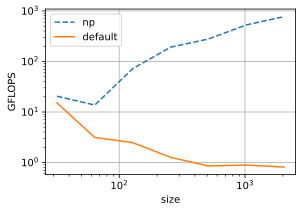

In [5]:
default_gflops = bench_matmul_tvm(default, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops], ['np', 'default'])

# Reordering Axes

In [7]:
def reorder(n):
    s, (A, B, C) = default(n)
    (x, y), (k,) = C.op.axis, C.op.reduce_axis
    s[C].reorder(x, k, y)
    return s, (A, B, C)

s, args = reorder(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i: int32, 0, 64) {
    for (j.init: int32, 0, 64) {
      C[((i*64) + j.init)] = 0f32
    }
    for (k: int32, 0, 64) {
      for (j: int32, 0, 64) {
        let cse_var_2: int32 = (i*64)
        let cse_var_1: int32 = (cse_var_2 + j)
        C[cse_var_1] = (C[cse_var_1] + (A[(cse_var_2 + k)]*B[((k*64) + j)]))
      }
    }
  }
}




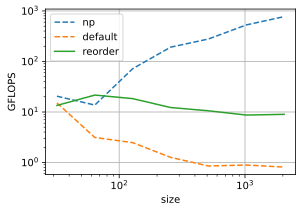

In [8]:
reorder_gflops = bench_matmul_tvm(reorder, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops], ['np', 'default', 'reorder'])

# Parallel

In [9]:
def parallel(n):
    s, (A, B, C) = reorder(n)
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i: int32, 0, 64) "parallel" {
    for (j.init: int32, 0, 64) {
      C[((i*64) + j.init)] = 0f32
    }
    for (k: int32, 0, 64) {
      for (j: int32, 0, 64) {
        let cse_var_2: int32 = (i*64)
        let cse_var_1: int32 = (cse_var_2 + j)
        C[cse_var_1] = (C[cse_var_1] + (A[(cse_var_2 + k)]*B[((k*64) + j)]))
      }
    }
  }
}




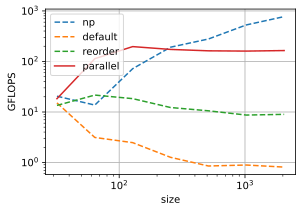

In [11]:
parallel_gflops = bench_matmul_tvm(parallel, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops, parallel_gflops], ['np', 'default', 'reorder', 'parallel'])

# Vectorize

In [12]:
def vectorize(n):
    s, (A, B, C) = default(n)
    (x, y), (k,) = C.op.axis, C.op.reduce_axis
    # reorder
    s[C].reorder(x, k, y)
    # parallel
    s[C].parallel(x)
    # vectorize
    s[C].vectorize(y)
    return s, (A, B, C)

s, args = vectorize(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i: int32, 0, 64) "parallel" {
    C[ramp((i*64), 1, 64)] = broadcast(0f32, 64)
    for (k: int32, 0, 64) {
      let cse_var_1: int32 = (i*64)
      C[ramp(cse_var_1, 1, 64)] = (C[ramp(cse_var_1, 1, 64)] + (broadcast(A[(cse_var_1 + k)], 64)*B[ramp((k*64), 1, 64)]))
    }
  }
}




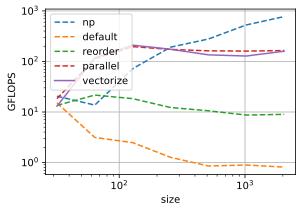

In [14]:
vectorize_gflops = bench_matmul_tvm(vectorize, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops, parallel_gflops, vectorize_gflops],
                  ['np', 'default', 'reorder', 'parallel', 'vectorize'])

# Summary
1.Reordering the for-loops in matrix multiplication properly improves the performance. \
2.Proper thread-level parallelization also improves the performance

# Exe

In [34]:
def parallel_2(n):
    s, (A, B, C) = default(n)
    (x, y), (k,) = C.op.axis, C.op.reduce_axis
    s[C].reorder(x, k, y)
#     s[C].parallel(y)
    return s, (A, B, C)

s, args = parallel_2(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i: int32, 0, 64) {
    for (j.init: int32, 0, 64) {
      C[((i*64) + j.init)] = 0f32
    }
    for (k: int32, 0, 64) {
      for (j: int32, 0, 64) {
        let cse_var_2: int32 = (i*64)
        let cse_var_1: int32 = (cse_var_2 + j)
        C[cse_var_1] = (C[cse_var_1] + (A[(cse_var_2 + k)]*B[((k*64) + j)]))
      }
    }
  }
}




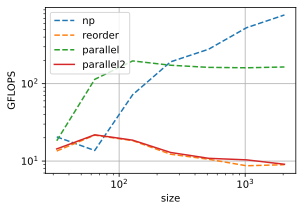

In [35]:
p2_gflops = bench_matmul_tvm(parallel_2, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, reorder_gflops, parallel_gflops, p2_gflops],
                  ['np', 'reorder', 'parallel', 'parallel2'])